<a href="https://colab.research.google.com/github/RealMyeong/Going_Deeper_NLP/blob/main/%5BNLP%5D_6_%EB%AA%A8%EB%93%A0%EC%9E%A5%EB%A5%B4%ED%8E%B8%ED%96%A5%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%bash
# apt-get update
# apt-get install g++ openjdk-8-jdk python-dev python3-dev
# pip3 install JPype1
# pip3 install konlpy


In [2]:
# %env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
# !pip install --upgrade gensim

In [4]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.2.0
1.0.2
0.11.2


## 1. 품사가 명사인 단어만 추출

synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장해보겠습니다.

토큰화에는 konlpy의 Okt를 사용하겠습니다.


In [5]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/6_임베딩편향성/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [6]:
print(len(tokenized))

71156


- konlpy의 Okt를 이용해서 품사가 명사인 단어만 추출해줍니다.

## 2. 추출된 단어로 Embedding 모델 만들기

tokenized에 담긴 데이터를 이용하여 Word2Vec을 생성합니다.

In [7]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  


In [33]:
model.wv.most_similar(positive = ['사랑'])

[('첫사랑', 0.6881195306777954),
 ('우정', 0.6856837272644043),
 ('만남', 0.6821410059928894),
 ('행복', 0.6802383661270142),
 ('비랄', 0.6800331473350525),
 ('애정', 0.6796112060546875),
 ('감정', 0.6757768392562866),
 ('아픔', 0.6713811159133911),
 ('운명', 0.6697307229042053),
 ('정일', 0.6697123050689697)]

In [34]:
model.wv.most_similar(positive = ['사고'])

[('교통사고', 0.8748798370361328),
 ('사망', 0.859982430934906),
 ('불의', 0.8473204374313354),
 ('화재', 0.8229140639305115),
 ('당한', 0.7792758941650391),
 ('실종', 0.7782414555549622),
 ('뺑소니', 0.7507299780845642),
 ('범', 0.749396026134491),
 ('살해', 0.735640287399292),
 ('발생', 0.7299107909202576)]

## 3. target, attribute 단어 셋 만들기

WEAT score를 구할 때 단어 셋을 만들어줘야함. targets_X, targets_Y, attribute_A, attribute_B를 만들어줘야 한다는 말.

두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야함

여기서 두 축을 영화 장르, 영화 구분 정보를 이용.(영화 구분 정보란 KOBIS에서 제공한 정보를 기준으로 분류)

- 영화 구분
  - synopsis_art.txt : 예술영화
  - synopsis_gen.txt : 일반영화(상업영화)
  - 그 외는 독립영화 등으로 분류됩니다.
- 장르 구분
  - synopsis_SF.txt: SF

  - synopsis_가족.txt: 가족

  - synopsis_공연.txt: 공연

  - synopsis_공포(호러).txt: 공포(호러)

  - synopsis_기타.txt: 기타

  - synopsis_다큐멘터리.txt: 다큐멘터리

  - synopsis_드라마.txt: 드라마

  - synopsis_멜로로맨스.txt: 멜로로맨스

  - synopsis_뮤지컬.txt: 뮤지컬

  - synopsis_미스터리.txt: 미스터리

  - synopsis_범죄.txt: 범죄

  - synopsis_사극.txt: 사극

  - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)

  - synopsis_성인물(에로).txt: 성인물(에로)

  - synopsis_스릴러.txt: 스릴러

  - synopsis_애니메이션.txt: 애니메이션

  - synopsis_액션.txt: 액션

  - synopsis_어드벤처.txt: 어드벤처

  - synopsis_전쟁.txt: 전쟁

  - synopsis_코미디.txt: 코미디

  - synopsis_판타지.txt: 판타지

예술 영화와 일반 영화(상업 영화)라는 영화 구분을 target으로 삼고, 장르 구분을 attribute로 삼아 WEAT score를 계산함.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 명사에 대해서만 단어를 추출하여 art, gen 변수에 할당

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/6_임베딩편향성/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [10]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요합니다. 

TF-IDF방식을 이용해 단어 셋을 구성 해주겠습니다.

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [12]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(300):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(300):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 청년, 한국, 가지, 상처, 할머니, 목숨, 이상, 희망, 계획, 매력, 프랑스, 사회, 제안, 만남, 무엇, 거리, 이유, 파리, 여성, 정체, 매일, 바로, 시절, 보고, 진실, 홀로, 혼란, 배우, 선택, 다큐멘터리, 혼자, 작가, 갑자기, 일본, 고향, 마주, 도착, 병원, 문제, 로부터, 노래, 주인공, 자리, 대해, 미래, 갈등, 소식, 공연, 서울, 할아버지, 부부, 도움, 연애, 회사, 여자친구, 조직, 소개, 낯선, 찾기, 애인, 잠시, 당신, 고백, 역시, 아무, 시골, 동료, 편지, 촬영, 과정, 영국, 오늘, 마침내, 지구, 마치, 자살, 뉴욕, 탈출, 무대, 주변, 학생, 열정, 발생, 고양이, 고민, 천재, 첫사랑, 더욱, 납치, 약속, 복수, 역사, 의문, 동네, 행복, 파티, 현재, 달리, 여정, 전설, 가슴, 다음, 사진, 행동, 스스로, 점차, 성공, 몰래, 등장, 살해, 부모, 누군가, 변화, 얼굴, 맞이, 작전, 전화, 목격, 나이, 남자친구, 인물, 스타, 대학, 중국, 북한, 위협, 진짜, 우정, 현장, 소설, 가정, 부모님, 주인, 의심, 시대, 카메라, 이별, 바다, 기회, 가게

두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출했습니다. 

하지만 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있습니다.

두 개념축이 서로 대조되도록 대표하는 단어 셋을 만들기 위해 단어가 서로 중복되지 않게 단어셋을 추출 해줍니다.

상위 100개의 단어 중 중복되는 단어를 제외하고 상위 30개의 단어를 추출합니다.

In [13]:
n = 30
w1_, w2_ = [], []
for i in range(300):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 30개 추출한다.
target_art, target_gen = [], []
for i in range(300):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 30개 추출한다.
for i in range(300):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [14]:
print(len(target_art), target_art)
print(len(target_gen), target_gen)

30 ['파리', '마주', '공연', '연애', '당신', '고백', '편지', '영국', '무대', '열정', '고양이', '천재', '첫사랑', '약속', '행복', '달리', '여정', '점차', '성공', '맞이', '스타', '북한', '진짜', '우정', '소설', '의심', '이별', '추억', '밴드', '생일']
30 ['애니메이션', '연출', '부문', '섹스', '의도', '그것', '독립', '경쟁', '부천', '페스티벌', '환경', '다큐', '공간', '영상', '판타스틱', '유혹', '노인', '공격', '표현', '시도', '요구', '청소년', '임무', '관객', '이미지', '작업', '장면', '운영', '제작', '바람']


이번에는 장르별 대표 단어를 추출해 보겠습니다. 

In [15]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt


def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/6_임베딩편향성/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [17]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


장르별 대표 단어를 30개씩 뽑아보겠습니다.

In [19]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 30):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 비밀, 사실, 기억, 전쟁, 사건, 시간, 공격, 영화, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 사람, 학교, 세상, 소년, 슈이트, 이야기, 가장, 어머니, 마갈, 소녀, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다, 무대, 도시, 공작, 리코, 시작, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 이야기, 비밀, 아이, 정체, 저주, 살해, 영화제, 여자, 모든, 의문, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 엄마, 통해, 아시아나, 다른, 우리, 연출, 소녀, 모습, 아이, 시간, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국, 작품, 환경, 사회, 모습, 아이, 마을, 노동자, 세상, 가장, 기록, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 마음, 아이, 남편, 서로, 시간, 소녀, 세상, 감독, 다른, 모든, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부,

## 4. WEAT score 계산과 시각화

이제 WEAT_score를 구해보겠습니다.

target_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션'과 같이 정해줄 수 있습니다.

현재 총 21개의 장르에대해 계산해야하기 때문에 계산 결과를 21 x 21매트릭스 형태로 표현해서 matrix 라는 변수에 담아 주겠습니다.


In [20]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

# 0으로 이루어진 matrix를 만들고 값을 변환해주겠습니다.
matrix

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

WEAT score를 계산하기 위한 함수 정의

In [21]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [22]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [23]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [24]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [25]:
A.shape

(30, 100)

matrix를 채웠으니 WEAT score값을 보고 우리의 직관과 비슷한지 한 번 살펴보겠습니다.

전부 보면 너무 많으니 5개정도만 뽑아서 보겠습니다.


In [26]:
for i in range(1):
    for j in range(i+1, 6):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.65891653
SF 공연 -0.16439506
SF 공포(호러) -0.48818853
SF 기타 0.27375928
SF 다큐멘터리 0.5462396


위 결과를 한 번 해석해보면 다음과 같습니다.
- 예술 영화와 일반 영화, 그리고 SF와 가족의 WEAT score의 의미를 해석하면 예술 영화는 가족, 일반 영화는 SF와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
- 예술 영화와 일반 영화, 그리고 SF와 다큐멘터리의 WEAT score의 의미를 해석하면 예술 영화는 SF, 일반 영화는 다큐멘터리와 가깝다고 볼 수 있습니다.

In [27]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

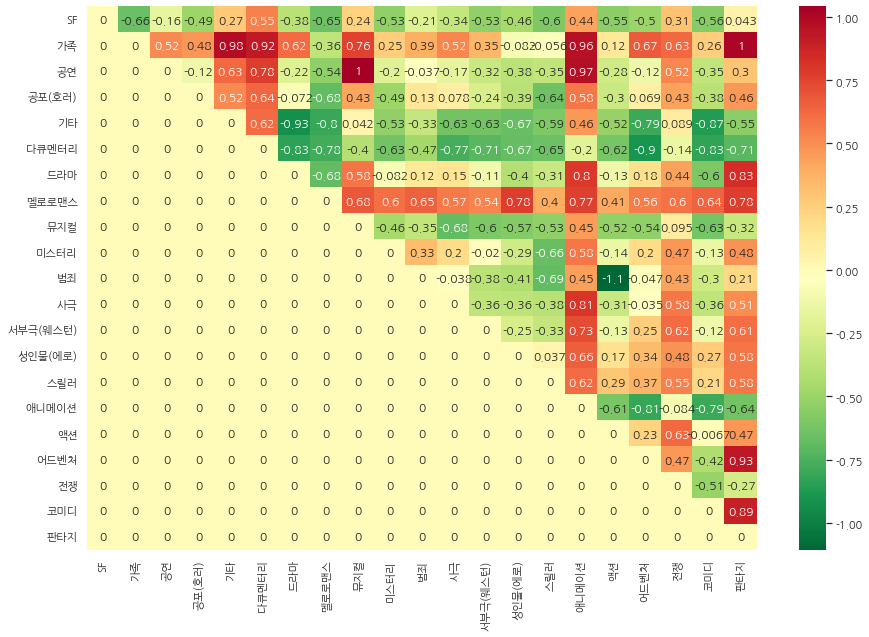

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax